In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [2]:
import tensorflow_datasets as tfds

In [3]:
train, test = tfds.load('mnist', as_supervised=True, shuffle_files=True, split=['train', 'test'])

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 256., label
def y_is_x(image, label):
    return image, image

train = train.map(normalize_img)
train = train.map(y_is_x)
train = train.batch(128)

    

### First we create a sampling layer to sample the codings

In [5]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return (keras.backend.random_normal(tf.shape(log_var)) * 
            keras.backend.exp(log_var / 2) + mean)

### Now we create the model

In [6]:
codings_size = 10

inputs = keras.layers.Input(shape=[28,28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation='selu')(z)
codings_mean = keras.layers.Dense(codings_size)(z) # u
codings_log_var = keras.layers.Dense(codings_size)(z) # y
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])


In [7]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation='selu')(decoder_inputs)
x = keras.layers.Dense(150, activation='selu')(x)
x = keras.layers.Dense(28*28, activation='sigmoid')(x)
outputs = keras.layers.Reshape([28,28])(x)

variational_decoder = keras.Model(
    inputs=[decoder_inputs], outputs=[outputs])

In [8]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

### Now we compute loss and compile the model

In [9]:
latent_loss = -0.5 * keras.backend.sum(
    1 + codings_log_var - keras.backend.exp(codings_log_var)
    - keras.backend.square(codings_mean), axis=-1)
# Compute mean over the batch, then divide by 784 to make to scale
# with the reconsutruction loss 
# (Keras cross entropy loss takes average rather than sum)
variational_ae.add_loss(keras.backend.mean(latent_loss) / 784.)
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [10]:
history = variational_ae.fit(train, epochs=1)

469/469 [==============================] - 15s 31ms/step - loss: 0.2208


## Generated Digits

#### After 1 epoch

In [11]:
codings = tf.random.normal(shape=[5, codings_size])
images = variational_decoder(codings).numpy()

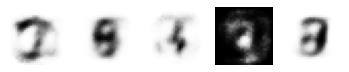

In [12]:
plt.figure()
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i], cmap='binary')
    plt.axis("off")

#### After 50 epochs

In [38]:
history = variational_ae.fit(train, epochs=50)

Epoch 1/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1865
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1864
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1863
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1862
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1861
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1860
Epoch 7/50
469/469 [==============================] - 4s 7ms/step - loss: 0.1859
Epoch 8/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1858
Epoch 9/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1857
Epoch 10/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1855
Epoch 11/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1855
Epoch 12/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1853
Epoch 13/50
469/469 [====

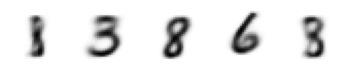

In [39]:
# Same sample as before
images = variational_decoder(codings).numpy()
plt.figure()
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i], cmap='binary')
    plt.axis("off")

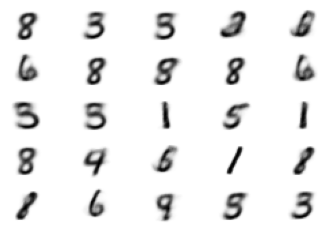

In [40]:
# new sample
codings = tf.random.normal(shape=[25, codings_size])
images = variational_decoder(codings).numpy()
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i], cmap='binary')
    plt.axis("off")

# Visualizing latent space

#### If we have the coding size be 2 for a model, we can very easily visualize the latent coding space that reuslts. This makes for a very interesting visualization, as we'll soon see

In [44]:
codings_size = 2

# This is the same as before 
inputs = keras.layers.Input(shape=[28,28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation='selu')(z)
codings_mean = keras.layers.Dense(codings_size)(z) # u
codings_log_var = keras.layers.Dense(codings_size)(z) # y
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation='selu')(decoder_inputs)
x = keras.layers.Dense(150, activation='selu')(x)
x = keras.layers.Dense(28*28, activation='sigmoid')(x)
outputs = keras.layers.Reshape([28,28])(x)

variational_decoder = keras.Model(
    inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae_2d = keras.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * keras.backend.sum(
    1 + codings_log_var - keras.backend.exp(codings_log_var)
    - keras.backend.square(codings_mean), axis=-1)
variational_ae_2d.add_loss(keras.backend.mean(latent_loss) / 784.)
variational_ae_2d.compile(loss='binary_crossentropy', optimizer='rmsprop')

history = variational_ae_2d.fit(train, epochs=50)

Epoch 1/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2546
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2238
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2161
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2118
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2085
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2060
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2040
Epoch 8/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2024
Epoch 9/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2010
Epoch 10/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1999
Epoch 11/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1988
Epoch 12/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1980
Epoch 13/50
469/469 [====

In [45]:
import tensorflow_probability as tfp
import numpy as np

def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

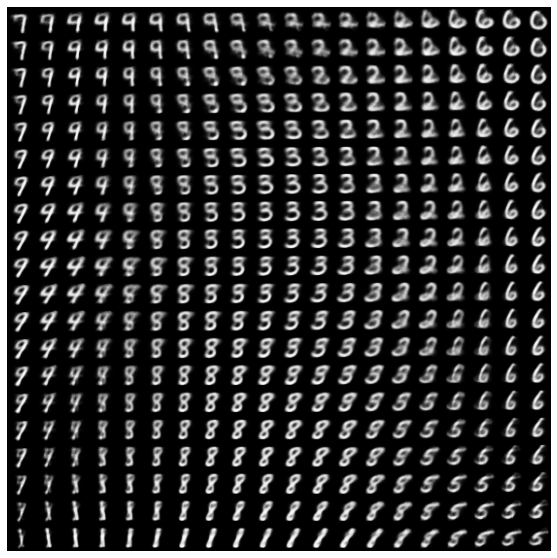

In [48]:
plot_latent_images(variational_decoder, 20)

#### Very, VERY cool!